In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scripts.utils import load_csv, split_date, drop_columns, simplify_df, split_data_frame, impute_rolling_median, add_seasonality, apply_functions, apply_moving_average_for_roc

### Preprocessing

In [2]:
df = load_csv('../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [5]:
train, val, test = split_data_frame(df, 0.7, 0.2)

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Foreca

In [9]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(16, activation='leaky_relu', return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(16, activation='leaky_relu')(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae','mape'])

    # Return the model
    return model

In [10]:
def fit(X_train, y_train, X_val, y_val):

    input_shape = (X_train.shape[1], X_train.shape[2])
    output_units = 1

    # Build and compile the model
    model = build_simple_LSTM_regressor(input_shape, output_units)
    model.summary()

    # Train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=64,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

    return model, history

In [11]:
model, history = fit(X_train, y_train, X_val, y_val)

Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 18)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 16)             2240      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 4369 (17.07 KB)
Trainable params: 4369 (17.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
423/423 [==============================] - 1s 2ms/step - loss: 0.0593 - mae: 0.1210 - mape: 26.1406 - val_loss: 0.0156 - val_mae: 0

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

def plot_results(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

846/846 [==============================] - 0s 463us/step


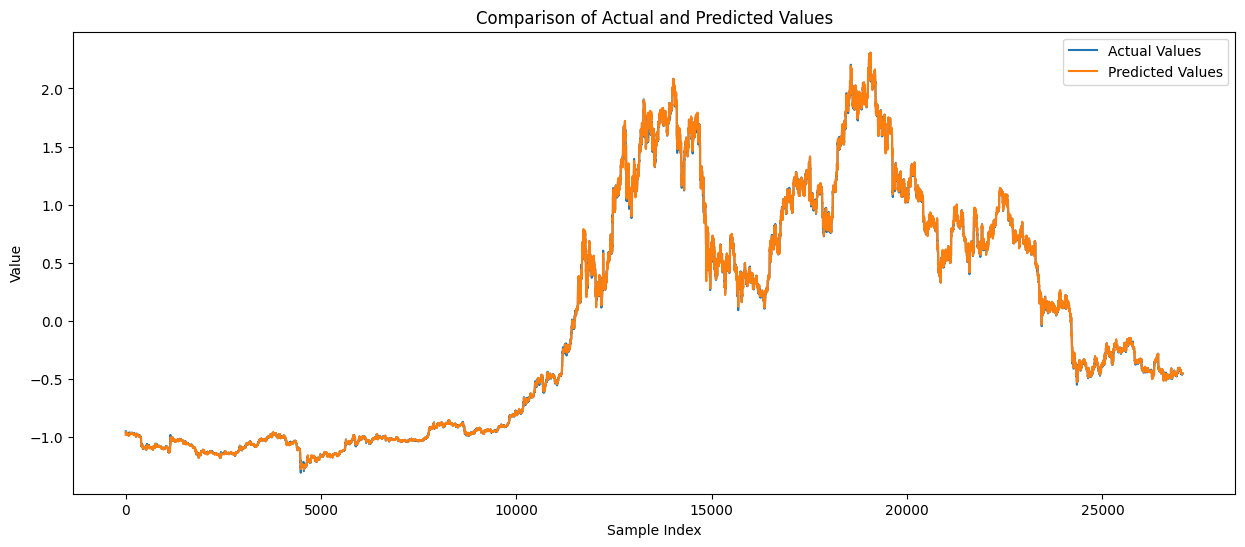

In [13]:
plot_results(model, X_train, y_train)

242/242 [==============================] - 0s 457us/step


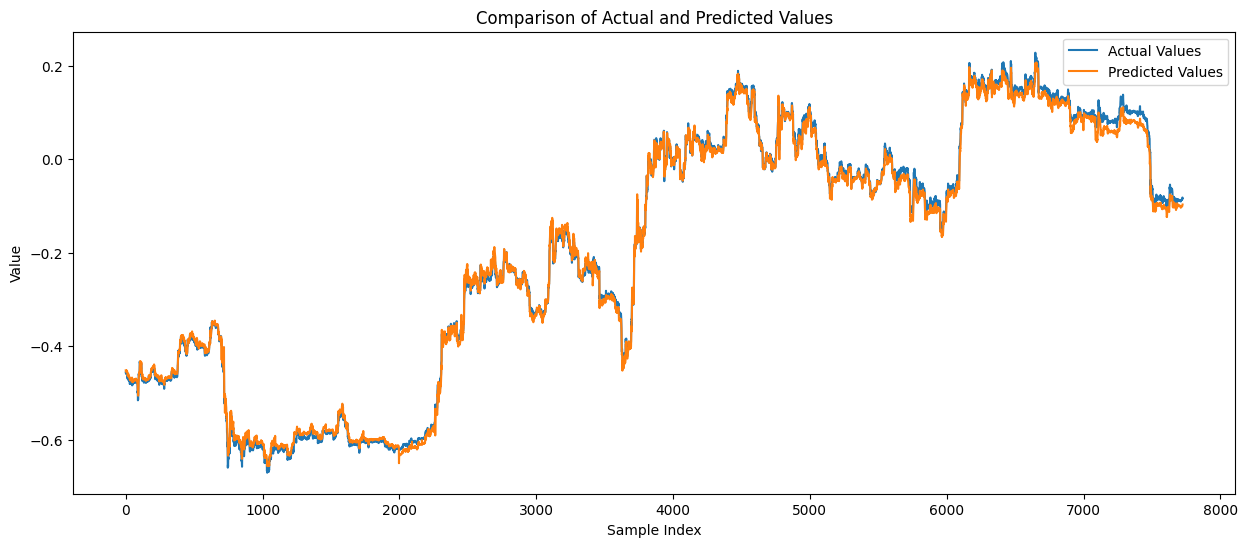

In [14]:
plot_results(model, X_val, y_val)

121/121 [==============================] - 0s 479us/step


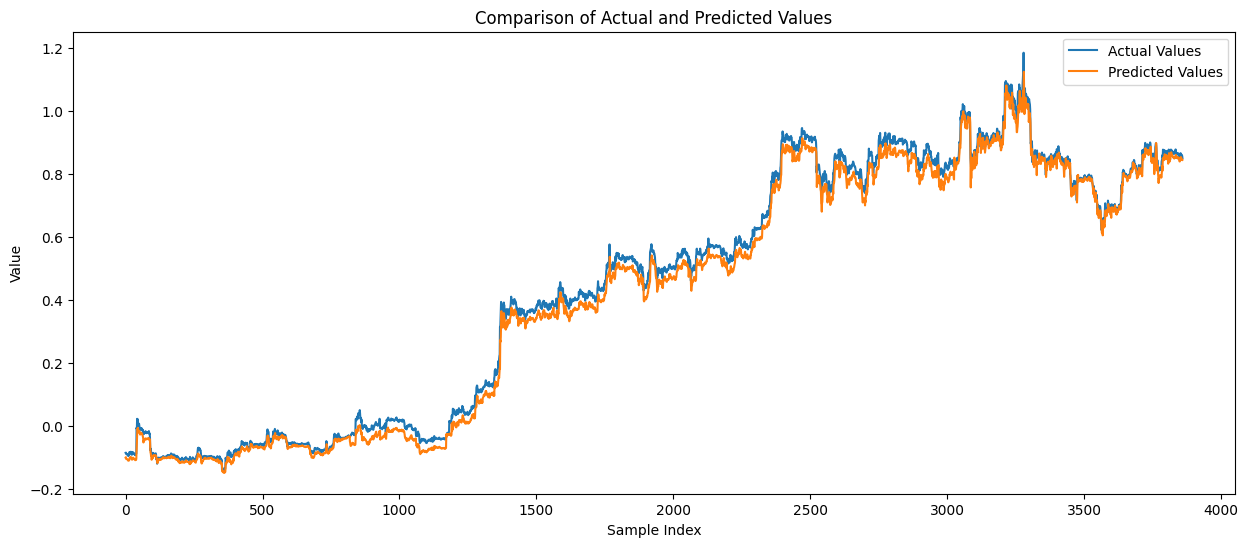

In [15]:
plot_results(model, X_test, y_test)

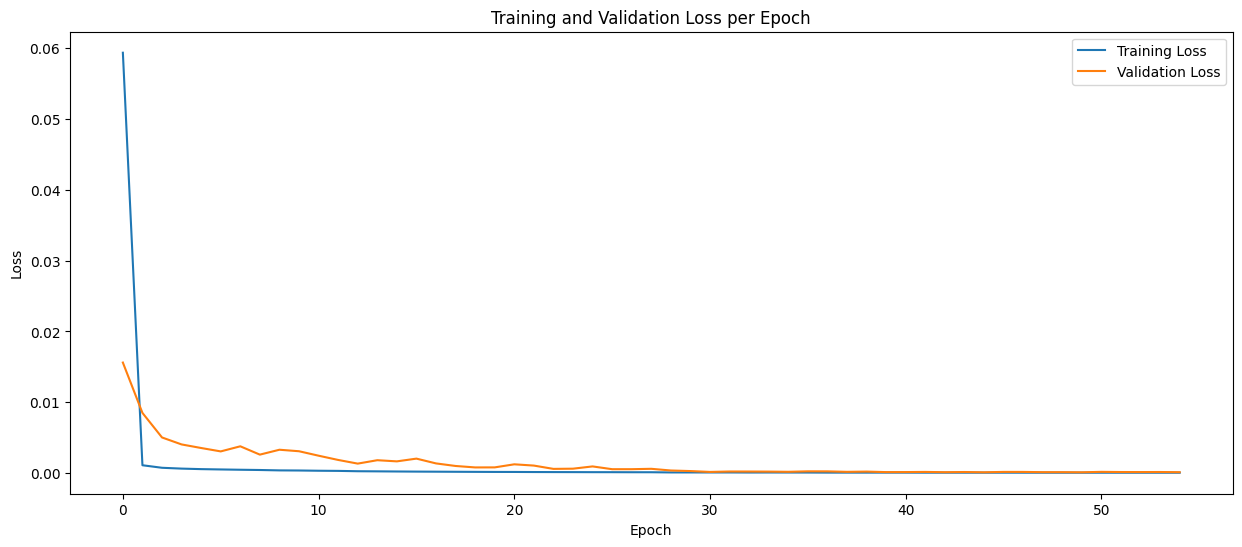

In [16]:
# Extracting loss data from the history object
train_loss = history['loss']
val_loss = history['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
summary = []

crypto = 'BTC'
lstm = 'LSTM'
mse, mae, mape = evaluate(model, X_test, y_test)

summary.append({
    'Data': crypto,
    'Model': lstm,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert list to DataFrame
lstm_df = pd.DataFrame(summary)
lstm_df

121/121 [==============================] - 0s 470us/step


,Data,Model,MSE,MAE,MAPE
0,BTC,LSTM,0.000898,0.026056,0.873848
